In [1]:
!pip install polars


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\romai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import requests
import zipfile
import io
import polars as pl


In [3]:
df_book_trades = pl.read_csv('BTCUSD_PERP-bookTicker-2024-10.csv')
df_book_trades

update_id,best_bid_price,best_bid_qty,best_ask_price,best_ask_qty,transaction_time,event_time
i64,f64,f64,f64,f64,i64,i64
1040037694559,63285.8,11.0,63285.9,4555.0,1727740800014,1727740800031
1040037723920,63285.8,11.0,63285.9,4563.0,1727740800114,1727740800170
1040037787516,63285.8,11.0,63285.9,4569.0,1727740800270,1727740800400
1040037787522,63285.8,2.0,63285.9,4569.0,1727740800270,1727740800400
1040037787543,63285.8,77.0,63285.9,4569.0,1727740800270,1727740800400
…,…,…,…,…,…,…
1049735799107,63880.5,4743.0,63880.6,176.0,1728885854968,1728885854977
1049735800034,63880.5,4793.0,63880.6,176.0,1728885855113,1728885855123
1049735800196,63880.5,4793.0,63880.6,177.0,1728885855128,1728885855132


In [4]:
df_trades = pl.read_csv('BTCUSD_PERP-aggTrades-2024-10.csv')
df_trades

agg_trade_id,price,quantity,first_trade_id,last_trade_id,transact_time,is_buyer_maker
i64,f64,f64,i64,i64,i64,bool
356937192,63285.8,1.0,868134906,868134906,1727740800804,true
356937193,63285.8,1.0,868134907,868134907,1727740801042,true
356937194,63285.8,1.0,868134908,868134908,1727740801778,true
356937195,63282.7,1.0,868134909,868134909,1727740801778,true
356937196,63282.1,1.0,868134910,868134910,1727740801828,false
…,…,…,…,…,…,…
361762904,70206.9,210.0,878060667,878060667,1730419178651,true
361762905,70207.0,1.0,878060668,878060668,1730419189161,false
361762906,70207.0,1.0,878060669,878060669,1730419189604,false


In [5]:
import polars as pl
import numpy as np

# Correction de l'étape 1
df_book = (
    df_book_trades  # Assurez-vous d'utiliser votre variable source (df_booktrades vs df_book_trades)
    .with_columns([
        # On spécifie explicitement que l'input est en millisecondes
        pl.from_epoch(pl.col("transaction_time"), time_unit="ms").alias("datetime"),
        
        # Calcul du Mid Price
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid_price")
    ])
    .sort("datetime")
)

# Correction de l'étape 2 (Resampling)
df_resampled = (
    df_book
    .group_by_dynamic("datetime", every="5s") # Bougies de 30 secondes
    .agg([
        pl.col("mid_price").first().alias("open"),
        pl.col("mid_price").max().alias("high"),
        pl.col("mid_price").min().alias("low"),
        pl.col("mid_price").last().alias("close"),
    ])
)

# Vérification : La shape doit être grande (ex: ~80k lignes pour un mois en 30s)
print(f"Nouvelle shape: {df_resampled.shape}")
print(df_resampled.head())

Nouvelle shape: (229008, 5)
shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ datetime[ms]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╡
│ 2024-10-01 00:00:00 ┆ 63285.85 ┆ 63285.85 ┆ 63282.05 ┆ 63282.05 │
│ 2024-10-01 00:00:05 ┆ 63282.05 ┆ 63297.35 ┆ 63282.05 ┆ 63297.35 │
│ 2024-10-01 00:00:10 ┆ 63297.35 ┆ 63307.75 ┆ 63297.35 ┆ 63307.75 │
│ 2024-10-01 00:00:15 ┆ 63307.75 ┆ 63307.75 ┆ 63307.75 ┆ 63307.75 │
│ 2024-10-01 00:00:20 ┆ 63307.75 ┆ 63315.15 ┆ 63307.75 ┆ 63315.15 │
└─────────────────────┴──────────┴──────────┴──────────┴──────────┘


In [6]:
# Mise à jour de l'étape de Rééchantillonnage
df_resampled_spread = (
    df_book
    .group_by_dynamic("datetime", every="5s")
    .agg([
        # On garde le Mid pour les calculs du VRT (le signal technique)
        pl.col("mid_price").last().alias("close"), 
        
        # On garde le Bid/Ask SPECIFIQUES pour l'exécution
        # Pour être conservateur, on prend le PIRE prix de la bougie, 
        # ou le dernier (last) pour simuler une exécution en fin de bougie.
        # Ici : exécution au 'last' de la bougie (clôture)
        pl.col("best_ask_price").last().alias("ask_close"),
        pl.col("best_bid_price").last().alias("bid_close"),
    ])
    # Calcul du Spread relatif (en points de base - bps) pour info
    .with_columns([
        ((pl.col("ask_close") - pl.col("bid_close")) / pl.col("close")).alias("spread_pct")
    ])
)

# Vérifions le spread moyen sur la période (pour voir si c'est tradable)
mean_spread = df_resampled_spread["spread_pct"].mean() * 10000
print(f"Spread moyen : {mean_spread:.2f} bps") 
# BTC est très liquide, ça devrait être autour de 1-2 bps (0.01%)

Spread moyen : 0.02 bps


In [7]:
!pip install numba


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\romai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import sys, subprocess

print(sys.executable)  # pour vérifier le Python utilisé par le notebook
subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow"])

C:\Users\romai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe


0

In [9]:
import sys
print("Python utilisé :", sys.executable)

import pyarrow as pa
print("pyarrow version :", pa.__version__)

Python utilisé : C:\Users\romai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe
pyarrow version : 22.0.0


Calcul du VRT en cours...


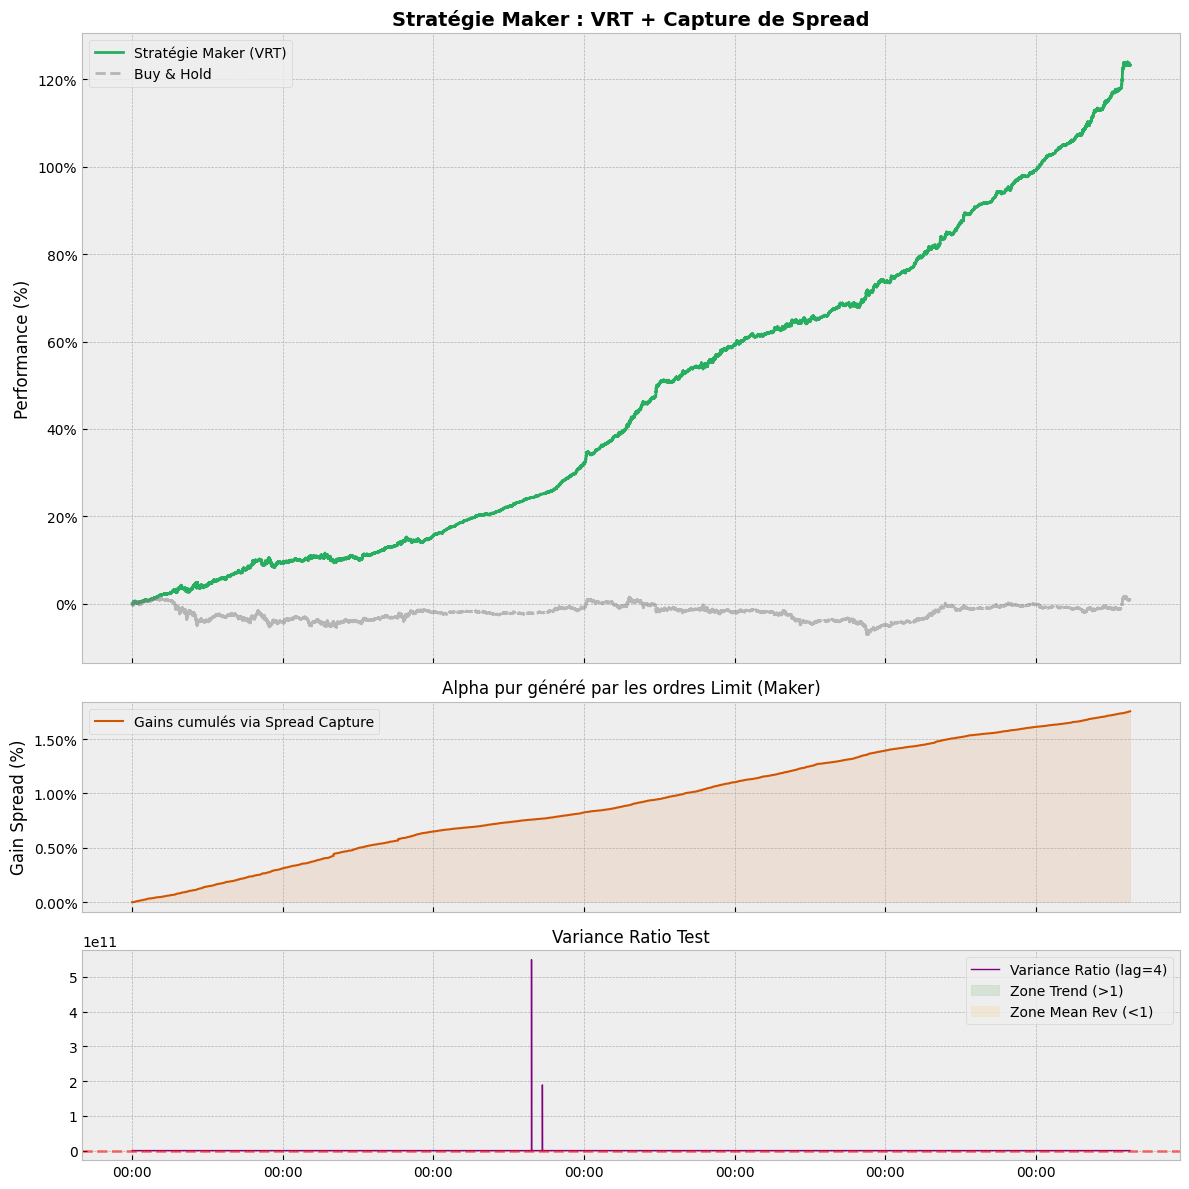

Performance Maker: 123.16%
Dont gains Spread: 1.75%


In [10]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick


def add_variance_ratio(df: pl.DataFrame, lag: int = 4, window: int = 120) -> pl.DataFrame:
    """
    Calcul du Variance Ratio Test:
    VR = Var(r_k) / (k * Var(r_1))
    VR < 1 : mean reversion ; VR > 1 : momentum.
    """
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            (pl.col("var_lag") / (pl.col("var_1") * lag)).fill_null(1.0).alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )


def run_maker_strategy(df_input, lag=4, window=120, maker_fee=-0.000):
    print("Calcul du VRT en cours...")
    df_with_vrt = add_variance_ratio(df_input, lag=lag, window=window)

    df_strategy = (
        df_with_vrt
        .with_columns([
            pl.col("close").ewm_mean(span=50).alias("ema_trend")
        ])
        .with_columns([
            pl.when((pl.col("vrt") > 1.0) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > 1.0) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )

    df_pnl = (
        df_strategy
        .with_columns([
            pl.col("signal").shift(1).fill_null(0).alias("pos")
        ])
        .with_columns([
            (pl.col("pos") - pl.col("pos").shift(1).fill_null(0)).alias("trade_action")
        ])
        .with_columns([
            pl.col("close").log().diff().fill_null(0).alias("market_ret_log"),
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")
        ])
        .with_columns([
            (pl.col("pos") * pl.col("market_ret_log")).alias("pnl_log_directional"),
            (pl.col("trade_action").abs() * (pl.col("half_spread_pct") - maker_fee)).alias("spread_capture")
        ])
        .with_columns([
            (pl.col("pnl_log_directional") + pl.col("spread_capture")).cum_sum().alias("equity_curve_log"),
            pl.col("spread_capture").cum_sum().alias("cum_spread_captured")
        ])
    )

    return df_pnl


if 'df_resampled_spread' in locals():
    df_maker_results = run_maker_strategy(df_resampled_spread)

    pdf_plot = df_maker_results.select([
        "datetime", "equity_curve_log", "market_ret_log", "cum_spread_captured", "trade_action", "vrt"
    ]).to_pandas()

    pdf_plot['strategy_pct'] = (np.exp(pdf_plot['equity_curve_log']) - 1) * 100
    pdf_plot['bnh_pct'] = (np.exp(pdf_plot['market_ret_log'].cumsum().fillna(0)) - 1) * 100
    pdf_plot['spread_gain_pct'] = (np.exp(pdf_plot['cum_spread_captured']) - 1) * 100

    plt.style.use('bmh')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

    ax1.plot(pdf_plot['datetime'], pdf_plot['strategy_pct'], label='Stratégie Maker (VRT)', color='#27ae60', linewidth=2)
    ax1.plot(pdf_plot['datetime'], pdf_plot['bnh_pct'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')
    ax1.set_title('Stratégie Maker : VRT + Capture de Spread', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Performance (%)')
    ax1.legend()
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax2.plot(pdf_plot['datetime'], pdf_plot['spread_gain_pct'], color='#d35400', label='Gains cumulés via Spread Capture', linewidth=1.5)
    ax2.fill_between(pdf_plot['datetime'], pdf_plot['spread_gain_pct'], 0, color='#d35400', alpha=0.1)
    ax2.set_title('Alpha pur généré par les ordres Limit (Maker)', fontsize=12)
    ax2.set_ylabel('Gain Spread (%)')
    ax2.legend()
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax3.plot(pdf_plot['datetime'], pdf_plot['vrt'], color='purple', label='Variance Ratio (lag=4)', linewidth=1)
    ax3.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    ax3.fill_between(pdf_plot['datetime'], pdf_plot['vrt'], 1.0, where=(pdf_plot['vrt'] > 1), color='green', alpha=0.1, label='Zone Trend (>1)')
    ax3.fill_between(pdf_plot['datetime'], pdf_plot['vrt'], 1.0, where=(pdf_plot['vrt'] < 1), color='orange', alpha=0.1, label='Zone Mean Rev (<1)')
    ax3.set_title('Variance Ratio Test', fontsize=12)
    ax3.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.tight_layout()
    plt.show()

    print(f"Performance Maker: {pdf_plot['strategy_pct'].iloc[-1]:.2f}%")
    print(f"Dont gains Spread: {pdf_plot['spread_gain_pct'].iloc[-1]:.2f}%")
else:
    print("Erreur: Le DataFrame 'df_resampled_spread' n'est pas défini. Veuillez charger les données d'abord.")

In [11]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def run_maker_strategy_decomposed(df_input, maker_fee=-0.0001, lag=4, window=120):
    """
    Décomposition maker basée sur le Variance Ratio Test pour générer le signal.
    maker_fee: négatif = rebate ; positif = coût.
    """

    df_step1 = add_variance_ratio(df_input, lag=lag, window=window).with_columns([
        pl.col("close").ewm_mean(span=50).alias("ema_trend")
    ]).with_columns([
        pl.when((pl.col("vrt") > 1.0) & (pl.col("close") > pl.col("ema_trend"))).then(pl.lit(1))
          .when((pl.col("vrt") > 1.0) & (pl.col("close") < pl.col("ema_trend"))).then(pl.lit(-1))
          .otherwise(pl.lit(0)).alias("signal")
    ])

    df_pnl = (
        df_step1
        .with_columns([
            pl.col("signal").shift(1).fill_null(0).alias("pos")
        ])
        .with_columns([
            (pl.col("pos") - pl.col("pos").shift(1).fill_null(0)).alias("trade_action"),
            pl.col("close").log().diff().fill_null(0).alias("market_ret_log"),
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")
        ])
        .with_columns([
            (pl.col("pos") * pl.col("market_ret_log")).alias("pnl_log_directional"),
            (pl.col("trade_action").abs() * (pl.col("half_spread_pct") - maker_fee)).alias("pnl_log_execution")
        ])
        .with_columns([
            pl.col("pnl_log_directional").cum_sum().alias("cum_pnl_directional"),
            pl.col("pnl_log_execution").cum_sum().alias("cum_pnl_execution"),
            (pl.col("pnl_log_directional") + pl.col("pnl_log_execution")).cum_sum().alias("cum_pnl_total")
        ])
    )

    return df_pnl


df_results = run_maker_strategy_decomposed(df_resampled_spread, maker_fee=-0.0001) # Rebate de 1bp

In [12]:
def print_performance_report(df_res):
    # On récupère les sommes finales
    total_trades = df_res["trade_action"].abs().sum()
    
    # Conversion Log returns -> Pourcentage simple approximatif
    total_dir_pct = df_res["pnl_log_directional"].sum() * 100
    total_exec_pct = df_res["pnl_log_execution"].sum() * 100
    total_net_pct = df_res["cum_pnl_total"].tail(1).item() * 100
    
    print("="*40)
    print("📊 DÉCOMPOSITION DU PnL (MAKER STRAT)")
    print("="*40)
    print(f"Nb de Trades       : {int(total_trades)}")
    print("-" * 40)
    print(f"1. PnL Directionnel: {total_dir_pct:+.2f} %  (Qualité du Signal)")
    print(f"2. PnL Exécution   : {total_exec_pct:+.2f} %  (Gains du Spread + Rebates)")
    print("-" * 40)
    print(f"🏁 TOTAL NET       : {total_net_pct:+.2f} %")
    print("="*40)
    
    if total_trades > 0:
        avg_trade = total_net_pct / total_trades
        print(f"Moyenne par trade  : {avg_trade*10000:.2f} bps")

# Afficher le rapport
print_performance_report(df_results)

📊 DÉCOMPOSITION DU PnL (MAKER STRAT)
Nb de Trades       : 21061
----------------------------------------
1. PnL Directionnel: +78.53 %  (Qualité du Signal)
2. PnL Exécution   : +212.35 %  (Gains du Spread + Rebates)
----------------------------------------
🏁 TOTAL NET       : +290.88 %
Moyenne par trade  : 138.11 bps


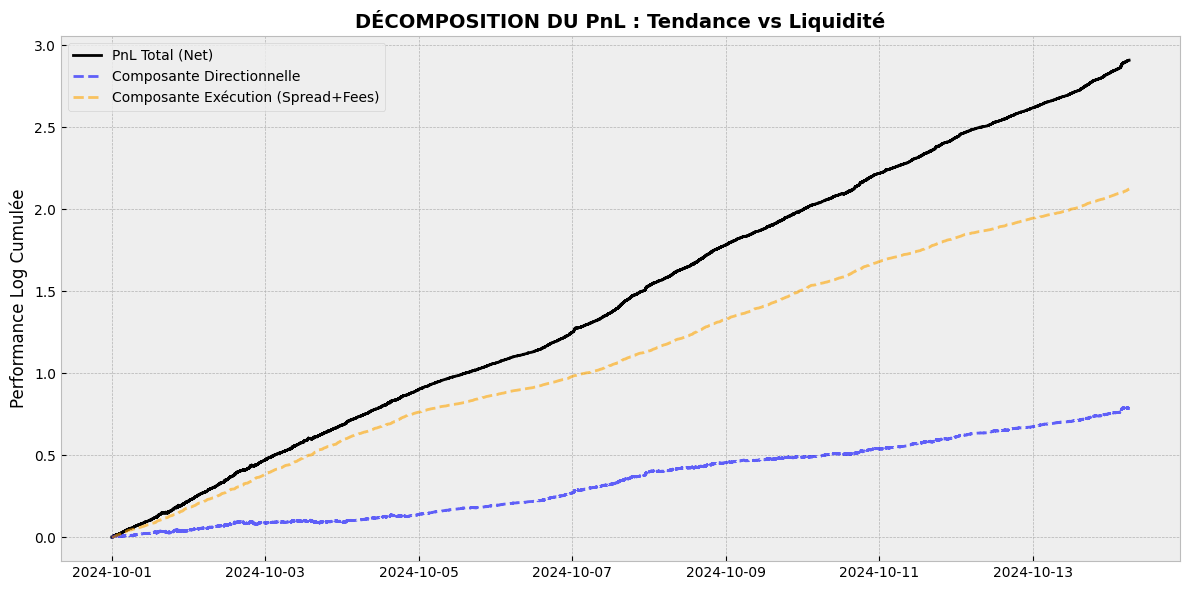

In [13]:
# Conversion Pandas pour plot
pdf = df_results.select(["datetime", "cum_pnl_directional", "cum_pnl_execution", "cum_pnl_total"]).to_pandas()

plt.figure(figsize=(12, 6))

# Zone empilée pour montrer la contribution
plt.plot(pdf['datetime'], pdf['cum_pnl_total'], label='PnL Total (Net)', color='black', linewidth=2)
plt.plot(pdf['datetime'], pdf['cum_pnl_directional'], label='Composante Directionnelle', color='blue', alpha=0.6, linestyle='--')
plt.plot(pdf['datetime'], pdf['cum_pnl_execution'], label='Composante Exécution (Spread+Fees)', color='orange', alpha=0.6, linestyle='--')

plt.title('DÉCOMPOSITION DU PnL : Tendance vs Liquidité', fontsize=14, fontweight='bold')
plt.ylabel('Performance Log Cumulée')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()